### The Buisness Problem
Joe is in the U.S. Navy and has been stationed with his family in Newport County, Rhode Island. Having no idea about the area, Joe found a place in the Melville area of Portsmouth, RI on the same Island as the base.  After visiting the area before moving in, Joe found that he prefers the Newport area due to its old historic neighborhood and scenic beaches, but his rental that he picked out is very close to the elementary school and he would like to live near an elementary school.  

Joe wants to find a similar neighborhood, close to an elementary school and much closer to the First and Second town beaches on southern aquidneck island.



In [1]:
import pandas as pd
import requests
import numpy as np
import folium
import matplotlib.cm as cm
import matplotlib.colors as colors
import json
from pandas.io.json import json_normalize
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


Waiting for a Spark session to start...
Spark Initialization Done! ApplicationId = app-20201111171128-0001
KERNEL_ID = cac53e70-1ba9-4c18-baf1-be241bed9f34


### I descided to take the list of Elementary schools in Rhode Island from Wikipedia and only add the ones from Newport County to my data frame.   Using Geopy, and reading about hte schools on thier wepages, I found some of hte info on the wiki to be incorrect, such as school no longer being open.  To deal with this I changed the name of the school to the city name and dropped some reduntant rows where the same name appeared.  I was left with 15 neighborhoods. 

In [2]:
wiki_url= "https://en.wikipedia.org/wiki/List_of_Rhode_Island_schools"
scdf=pd.read_html(wiki_url, match="Elementary")
scdf=scdf[0]
scdf=scdf[scdf.County.str.contains("Newport")]
scdf.reset_index(drop =True, inplace=True)
scdf.drop(["County", "District", "Students"], axis=1, inplace=True)
newp_df = scdf['City'].apply(lambda x: pd.Series(x.split(', ')))
newp_df=scdf.join(newp_df)
newp_df.drop("City", axis = 1, inplace=True)
newp_df.rename(columns={0: "City", 1: "State", "School Name": "School"}, inplace = True)
newp_df['School'].replace(to_replace=[
    'Jamestown School-Melrose','Wilbur & McMahon Schools', 'Ranger School', 'Sullivan School', 'Linden School'],
    value=['Jamestown','Little Compton', 'Tiverton', 'Newport', 'Middletown'],inplace=True)
newp_df.drop([2, 8, 16], axis=0,inplace=True)
newp_df.reset_index(inplace=True, drop=True)
newp_df

,School,City,State
0,Aquidneck School,Middletown,Rhode Island
1,Carey School,Newport,Rhode Island
2,Elmhurst School,Portsmouth,Rhode Island
3,Forest Avenue School,Middletown,Rhode Island
4,Fort Barton School,Tiverton,Rhode Island
5,Howard Hathaway School,Portsmouth,Rhode Island
6,Jamestown,Jamestown,Rhode Island
7,Middletown,Middletown,Rhode Island
8,Melville School,Portsmouth,Rhode Island
9,Nonquit School,Tiverton,Rhode Island


### I used geopy to find the latitude and longitude for each neighborhood and plotted them on a map.

In [3]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="greg_app")
p= [(41.0,-71.5), (42,-70.0)]

tmp = newp_df.copy()

latlon = tmp.School.apply(lambda addr: geolocator.geocode(addr, viewbox=p, bounded=True))

tmp["Latitude"] = [x.latitude for x in latlon]
tmp["Longitude"] = [x.longitude for x in latlon]
tmp

,School,City,State,Latitude,Longitude
0,Aquidneck School,Middletown,Rhode Island,41.496769,-71.280883
1,Carey School,Newport,Rhode Island,41.474825,-71.311717
2,Elmhurst School,Portsmouth,Rhode Island,41.544269,-71.243381
3,Forest Avenue School,Middletown,Rhode Island,41.525649,-71.287157
4,Fort Barton School,Tiverton,Rhode Island,41.624943,-71.209562
5,Howard Hathaway School,Portsmouth,Rhode Island,41.616213,-71.243937
6,Jamestown,Jamestown,Rhode Island,41.497047,-71.367276
7,Middletown,Middletown,Rhode Island,41.545658,-71.291439
8,Melville School,Portsmouth,Rhode Island,41.587046,-71.283383
9,Nonquit School,Tiverton,Rhode Island,41.571770,-71.192546


In [4]:
# create map  using latitude and longitude values
map_newp = folium.Map(location=[41.496769,-71.280883], zoom_start=10)

# add markers to map
for lat, lng, city, school in zip(tmp['Latitude'], tmp['Longitude'], tmp['City'], tmp['School']):
    label = '{}, {}'.format(school, city)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newp)  
    
map_newp

### As you can see Melville is closer to the north of the island, with the beaches Joe wishes to live near on ths southern shores of the island.  There seems to be 3-4 more neighborhoods closer to the beach, so I just needed to see if they are similar in the type of venues.  I will use K means clustering to find similar neighborhoods.

In [5]:
CLIENT_ID = 'KMED0QMTLPT5QNS3D4DKJ15L2JQLVNB3OHEXMETVS4LP0XPC' # your Foursquare ID
CLIENT_SECRET = 'B5OPZZ2DH3FCFDGKFFMOWKEBREYMF1Z3CRXKWZFXJQMNJBIY' # your Foursquare Secret
VERSION = '20201015' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: KMED0QMTLPT5QNS3D4DKJ15L2JQLVNB3OHEXMETVS4LP0XPC
CLIENT_SECRET:B5OPZZ2DH3FCFDGKFFMOWKEBREYMF1Z3CRXKWZFXJQMNJBIY


In [6]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Child care: 5744ccdfe4b0c0459246b4c7
DayCare: 4f4532974b9074f6e4fb0104
Nursery School: 4f4533814b9074f6e4fb0107
Preschool: 52e81612bcbc57f1066b7a45

In [7]:
def getNearbyVenues(names, latitudes, longitudes, radius=2000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius,
            LIMIT,
            )
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['School', 
                  'School Latitude', 
                  'School Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude',        
                  'Venue Category']
    
    return(nearby_venues)

In [8]:
Newport_venues = getNearbyVenues(names=tmp['School'],
                                   latitudes=tmp['Latitude'],
                                   longitudes=tmp['Longitude']
                                  )

Aquidneck School
Carey School
Elmhurst School
Forest Avenue School
Fort Barton School
Howard Hathaway School
Jamestown
Middletown
Melville School
Nonquit School
Pocasset School
Prudence Island School
Tiverton
Newport
Little Compton


In [9]:
print(Newport_venues.shape)
Newport_venues.head()

(520, 7)


,School,School Latitude,School Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Aquidneck School,41.496769,-71.280883,Newport Beach,41.488864,-71.281716,Beach
1,Aquidneck School,41.496769,-71.280883,Atlantic Grille,41.492130,-71.284040,Diner
2,Aquidneck School,41.496769,-71.280883,Newport County YMCA,41.498360,-71.286326,Gym
3,Aquidneck School,41.496769,-71.280883,Flo's Clam Shack,41.490032,-71.284916,Seafood Restaurant
4,Aquidneck School,41.496769,-71.280883,Easton's Beach,41.488658,-71.290326,Beach


In [10]:
Newport_venues.groupby('School').count()
print('There are {} uniques categories.'.format(len(Newport_venues['Venue Category'].unique())))

There are 140 uniques categories.


In [11]:
# one hot encoding
Newport_onehot = pd.get_dummies(Newport_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Newport_onehot['School'] = Newport_venues['School'] 



Newport_onehot.head()

,Airport,American Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Athletics & Sports,Australian Restaurant,Auto Dealership,BBQ Joint,Bagel Shop,...,Video Game Store,Video Store,Vietnamese Restaurant,Vineyard,Warehouse Store,Wine Shop,Winery,Women's Store,Yoga Studio,School
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Aquidneck School
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Aquidneck School
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Aquidneck School
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Aquidneck School
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Aquidneck School


In [12]:
Newport_grouped=Newport_onehot.groupby('School').mean().reset_index()
Newport_grouped

,School,Airport,American Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Athletics & Sports,Australian Restaurant,Auto Dealership,BBQ Joint,...,Trail,Video Game Store,Video Store,Vietnamese Restaurant,Vineyard,Warehouse Store,Wine Shop,Winery,Women's Store,Yoga Studio
0,Aquidneck School,0.000000,0.063830,0.000000,0.00,0.000000,0.021277,0.00,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00
1,Carey School,0.000000,0.060000,0.000000,0.02,0.000000,0.000000,0.01,0.000000,0.010000,...,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.01
2,Elmhurst School,0.000000,0.000000,0.000000,0.00,0.000000,0.111111,0.00,0.000000,0.000000,...,0.222222,0.000000,0.000000,0.000000,0.111111,0.000000,0.000000,0.000000,0.000000,0.00
3,Forest Avenue School,0.034091,0.000000,0.000000,0.00,0.011364,0.000000,0.00,0.011364,0.011364,...,0.000000,0.011364,0.000000,0.011364,0.011364,0.011364,0.011364,0.011364,0.000000,0.00
4,Fort Barton School,0.000000,0.173913,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,...,0.043478,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00
5,Howard Hathaway School,0.000000,0.150000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,...,0.000000,0.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00
6,Jamestown,0.000000,0.032258,0.000000,0.00,0.000000,0.032258,0.00,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00
7,Little Compton,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00
8,Melville School,0.000000,0.111111,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.055556,0.000000,0.055556,0.00
9,Middletown,0.103448,0.000000,0.000000,0.00,0.034483,0.000000,0.00,0.034483,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00


In [13]:
num_top_venues = 5

for hood in Newport_grouped['School']:
    print("----"+hood+"----")
    temp = Newport_grouped[Newport_grouped['School'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Aquidneck School----
                 venue  freq
0   Seafood Restaurant  0.06
1  American Restaurant  0.06
2          Pizza Place  0.06
3                Beach  0.06
4          Coffee Shop  0.04


----Carey School----
                 venue  freq
0                Hotel  0.06
1   Seafood Restaurant  0.06
2  American Restaurant  0.06
3        Historic Site  0.05
4                  Pub  0.04


----Elmhurst School----
                venue  freq
0                Park  0.22
1               Trail  0.22
2  Italian Restaurant  0.11
3  Athletics & Sports  0.11
4         Golf Course  0.11


----Forest Avenue School----
                  venue  freq
0                 Hotel  0.08
1                Bakery  0.03
2        Sandwich Place  0.03
3  Gym / Fitness Center  0.03
4            Donut Shop  0.03


----Fort Barton School----
                 venue  freq
0  American Restaurant  0.17
1      Harbor / Marina  0.13
2                 Café  0.09
3         Liquor Store  0.09
4          Coffee Shop  0

In [14]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [15]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['School']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['School'] = Newport_grouped['School']

for ind in np.arange(Newport_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Newport_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,School,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Aquidneck School,American Restaurant,Seafood Restaurant,Beach,Pizza Place,Scenic Lookout,Gym,Restaurant,Convenience Store,Coffee Shop,Gluten-free Restaurant
1,Carey School,Seafood Restaurant,American Restaurant,Hotel,Historic Site,Pub,Café,Burger Joint,Breakfast Spot,Dessert Shop,Park
2,Elmhurst School,Trail,Park,Vineyard,Beach,Athletics & Sports,Italian Restaurant,Golf Course,Yoga Studio,Farm,Food
3,Forest Avenue School,Hotel,Airport,Bakery,Donut Shop,Gym / Fitness Center,Coffee Shop,Department Store,Sandwich Place,Brewery,Gym
4,Fort Barton School,American Restaurant,Harbor / Marina,Café,Coffee Shop,Liquor Store,Bar,French Restaurant,Breakfast Spot,Massage Studio,Fast Food Restaurant
5,Howard Hathaway School,American Restaurant,Hostel,Beach,Grocery Store,Liquor Store,Food,Fast Food Restaurant,Donut Shop,Pharmacy,Pizza Place
6,Jamestown,Harbor / Marina,Hotel,Ice Cream Shop,Beach,City,Seafood Restaurant,Fish Market,Liquor Store,Breakfast Spot,Hardware Store
7,Little Compton,Pizza Place,Gift Shop,Breakfast Spot,Post Office,Thrift / Vintage Store,Café,Fish Market,Fast Food Restaurant,Farm,Falafel Restaurant
8,Melville School,Harbor / Marina,American Restaurant,Pizza Place,Museum,Café,Campground,Garden,Park,Lingerie Store,Light Rail Station
9,Middletown,Airport,Sporting Goods Shop,Gas Station,Cosmetics Shop,Coffee Shop,Pet Store,Other Great Outdoors,Shoe Store,Farm,Fast Food Restaurant


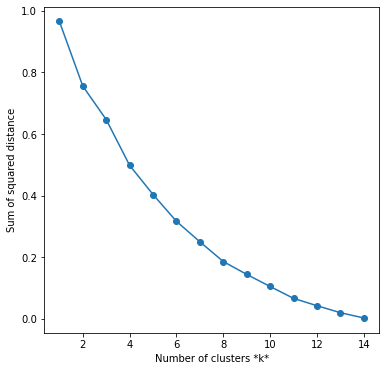

In [16]:
# Run the Kmeans algorithm and get the index of data points clusters
sse = []
list_k = list(range(1, 15))
Newport_grouped_clustering = Newport_grouped.drop('School', 1)
for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(Newport_grouped_clustering)
    sse.append(km.inertia_)

# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance');

### Using the elbow method to evaluate the clustering, It is evident that the graph follows a linear plot up until 6, after 6 the graph changes into a polynomial plot with a definate curve.  I chose to use k=6.

In [17]:
# set number of clusters
kclusters = 6



# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Newport_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 2, 0, 0, 0, 0, 3, 0, 0], dtype=int32)

In [18]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

Newport_merged = tmp

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
Newport_merged = Newport_merged.join(neighborhoods_venues_sorted.set_index('School'), on='School')

Newport_merged

,School,City,State,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Aquidneck School,Middletown,Rhode Island,41.496769,-71.280883,0,American Restaurant,Seafood Restaurant,Beach,Pizza Place,Scenic Lookout,Gym,Restaurant,Convenience Store,Coffee Shop,Gluten-free Restaurant
1,Carey School,Newport,Rhode Island,41.474825,-71.311717,0,Seafood Restaurant,American Restaurant,Hotel,Historic Site,Pub,Café,Burger Joint,Breakfast Spot,Dessert Shop,Park
2,Elmhurst School,Portsmouth,Rhode Island,41.544269,-71.243381,2,Trail,Park,Vineyard,Beach,Athletics & Sports,Italian Restaurant,Golf Course,Yoga Studio,Farm,Food
3,Forest Avenue School,Middletown,Rhode Island,41.525649,-71.287157,0,Hotel,Airport,Bakery,Donut Shop,Gym / Fitness Center,Coffee Shop,Department Store,Sandwich Place,Brewery,Gym
4,Fort Barton School,Tiverton,Rhode Island,41.624943,-71.209562,0,American Restaurant,Harbor / Marina,Café,Coffee Shop,Liquor Store,Bar,French Restaurant,Breakfast Spot,Massage Studio,Fast Food Restaurant
5,Howard Hathaway School,Portsmouth,Rhode Island,41.616213,-71.243937,0,American Restaurant,Hostel,Beach,Grocery Store,Liquor Store,Food,Fast Food Restaurant,Donut Shop,Pharmacy,Pizza Place
6,Jamestown,Jamestown,Rhode Island,41.497047,-71.367276,0,Harbor / Marina,Hotel,Ice Cream Shop,Beach,City,Seafood Restaurant,Fish Market,Liquor Store,Breakfast Spot,Hardware Store
7,Middletown,Middletown,Rhode Island,41.545658,-71.291439,0,Airport,Sporting Goods Shop,Gas Station,Cosmetics Shop,Coffee Shop,Pet Store,Other Great Outdoors,Shoe Store,Farm,Fast Food Restaurant
8,Melville School,Portsmouth,Rhode Island,41.587046,-71.283383,0,Harbor / Marina,American Restaurant,Pizza Place,Museum,Café,Campground,Garden,Park,Lingerie Store,Light Rail Station
9,Nonquit School,Tiverton,Rhode Island,41.571770,-71.192546,4,Deli / Bodega,Cheese Shop,American Restaurant,Art Gallery,Arts & Crafts Store,Ice Cream Shop,Flower Shop,Gift Shop,Farm,Food & Drink Shop


In [19]:
# create map
map_clusters = folium.Map(location=[41.496769,-71.280883], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Newport_merged['Latitude'], Newport_merged['Longitude'], Newport_merged['School'], Newport_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Cluster 0 List


In [20]:
Newport_merged.loc[Newport_merged['Cluster Labels'] == 0, Newport_merged.columns[[0] + list(range(5, Newport_merged.shape[1]))]]

,School,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Aquidneck School,0,American Restaurant,Seafood Restaurant,Beach,Pizza Place,Scenic Lookout,Gym,Restaurant,Convenience Store,Coffee Shop,Gluten-free Restaurant
1,Carey School,0,Seafood Restaurant,American Restaurant,Hotel,Historic Site,Pub,Café,Burger Joint,Breakfast Spot,Dessert Shop,Park
3,Forest Avenue School,0,Hotel,Airport,Bakery,Donut Shop,Gym / Fitness Center,Coffee Shop,Department Store,Sandwich Place,Brewery,Gym
4,Fort Barton School,0,American Restaurant,Harbor / Marina,Café,Coffee Shop,Liquor Store,Bar,French Restaurant,Breakfast Spot,Massage Studio,Fast Food Restaurant
5,Howard Hathaway School,0,American Restaurant,Hostel,Beach,Grocery Store,Liquor Store,Food,Fast Food Restaurant,Donut Shop,Pharmacy,Pizza Place
6,Jamestown,0,Harbor / Marina,Hotel,Ice Cream Shop,Beach,City,Seafood Restaurant,Fish Market,Liquor Store,Breakfast Spot,Hardware Store
7,Middletown,0,Airport,Sporting Goods Shop,Gas Station,Cosmetics Shop,Coffee Shop,Pet Store,Other Great Outdoors,Shoe Store,Farm,Fast Food Restaurant
8,Melville School,0,Harbor / Marina,American Restaurant,Pizza Place,Museum,Café,Campground,Garden,Park,Lingerie Store,Light Rail Station
10,Pocasset School,0,American Restaurant,Pharmacy,Pizza Place,Convenience Store,Food & Drink Shop,Portuguese Restaurant,Coffee Shop,Discount Store,Chinese Restaurant,Donut Shop
13,Newport,0,Seafood Restaurant,American Restaurant,Bar,Hotel,Park,Pub,Bed & Breakfast,Coffee Shop,Café,Dessert Shop


### The map and cluster zero shows that The Melville, Newport, Carey School, and Aquidneck Schools fall into the same cluster so they are similar.  In the analysis I will further compare thre neighborhoods, and find the distances to various locations Joe has specified.

In [21]:
#Create a df frame with the beach names and adresses
d = {'Beach': ['Eastons Beach', 'Second Beach', 'Third Beach'], 'Address': ['175 Memorial Blvd', '315 Sachuest Point Rd', 'Hanging Rock rd' ]}
beachesdf = pd.DataFrame(data=d)

#retrieve the coordinates from geopy
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="greg_app")
p= [(41.0,-71.5), (42,-70.0)]

tmpbea = beachesdf.copy()

latlon = tmpbea.Address.apply(lambda addr: geolocator.geocode(addr, viewbox=p, bounded=True))

beachesdf["Latitude"] = [x.latitude for x in latlon]
beachesdf["Longitude"] = [x.longitude for x in latlon]
beachesdf

,Beach,Address,Latitude,Longitude
0,Eastons Beach,175 Memorial Blvd,41.488688,-71.289938
1,Second Beach,315 Sachuest Point Rd,41.480221,-71.244117
2,Third Beach,Hanging Rock rd,41.492463,-71.258064


In [22]:
#now remove the unneded columns from the town dataframe
towndf = tmp[['School', 'Latitude', 'Longitude']]
towndf.head()

,School,Latitude,Longitude
0,Aquidneck School,41.496769,-71.280883
1,Carey School,41.474825,-71.311717
2,Elmhurst School,41.544269,-71.243381
3,Forest Avenue School,41.525649,-71.287157
4,Fort Barton School,41.624943,-71.209562


In [23]:
#the next stp was to stepthrough the town table for each beach and calulate the distance to each beach
coordinates_from=[beachesdf.Latitude[0], beachesdf.Longitude[0]]
coordinates_from

[41.4886884, -71.289938]

In [24]:
from geopy import distance
coordinates_from=[beachesdf.Latitude[0], beachesdf.Longitude[0]]

distance_km=[]
for n in towndf.index:
    
    coordinates_to = [towndf.Latitude[n], towndf.Longitude[n]]
    distance_tmp = distance.distance(coordinates_from, coordinates_to).km
    distance_km.append((distance_tmp))

towndf['km to Easton Beach']=distance_km
#After claculating the distanecs and saving them to a list, the list is ammended to the town dataframe
distance_km=[]
coordinates_from=[beachesdf.Latitude[1], beachesdf.Longitude[1]]
#Now I repeat for the Second Beach
for n in towndf.index:
    coordinates_to = [towndf.Latitude[n], towndf.Longitude[n]]
    distance_tmp = distance.distance(coordinates_from, coordinates_to).km
    distance_km.append((distance_tmp))
    
towndf['km to 2nd Beach']=distance_km
#and the Third beach
distance_km=[]
coordinates_from=[beachesdf.Latitude[2], beachesdf.Longitude[2]]

for n in towndf.index:
    coordinates_to = [towndf.Latitude[n], towndf.Longitude[n]]
    distance_tmp = distance.distance(coordinates_from, coordinates_to).km
    distance_km.append((distance_tmp))
towndf['km to 3rd Beach']=distance_km 

towndf

/opt/ibm/conda/miniconda/lib/python/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,School,Latitude,Longitude,km to Easton Beach,km to 2nd Beach,km to 3rd Beach
0,Aquidneck School,41.496769,-71.280883,1.173563,3.578394,1.964545
1,Carey School,41.474825,-71.311717,2.383166,5.678018,4.890447
2,Elmhurst School,41.544269,-71.243381,7.294505,7.113703,5.882888
3,Forest Avenue School,41.525649,-71.287157,4.111587,6.194339,4.414104
4,Fort Barton School,41.624943,-71.209562,16.552018,16.329968,15.260009
5,Howard Hathaway School,41.616213,-71.243937,14.674258,15.103927,13.794724
6,Jamestown,41.497047,-71.367276,6.524467,10.453443,9.133674
7,Middletown,41.545658,-71.291439,6.328485,8.271915,6.531900
8,Melville School,41.587046,-71.283383,10.937762,12.308694,10.715206
9,Nonquit School,41.571770,-71.192546,12.296712,11.041273,10.367236


In [25]:
#Remove lattitude and longitude
avgdis=towndf.drop(['Latitude','Longitude'],axis=1)

In [26]:
#calculate the average distances
avgdis['average distance']=avgdis.mean(axis=1)
avgdis.head()

,School,km to Easton Beach,km to 2nd Beach,km to 3rd Beach,average distance
0,Aquidneck School,1.173563,3.578394,1.964545,2.238834
1,Carey School,2.383166,5.678018,4.890447,4.317210
2,Elmhurst School,7.294505,7.113703,5.882888,6.763698
3,Forest Avenue School,4.111587,6.194339,4.414104,4.906677
4,Fort Barton School,16.552018,16.329968,15.260009,16.047331


In [27]:
#Reset the index to the scools and sort them by average distance
avgdis.set_index('School', inplace=True)
avgdis=avgdis.sort_values('average distance')
avgdis

,km to Easton Beach,km to 2nd Beach,km to 3rd Beach,average distance
School,,,,
Aquidneck School,1.173563,3.578394,1.964545,2.238834
Newport,1.995450,5.917318,4.660073,4.190947
Carey School,2.383166,5.678018,4.890447,4.317210
Forest Avenue School,4.111587,6.194339,4.414104,4.906677
Elmhurst School,7.294505,7.113703,5.882888,6.763698
Middletown,6.328485,8.271915,6.531900,7.044100
Little Compton,10.198550,6.937368,7.515619,8.217179
Jamestown,6.524467,10.453443,9.133674,8.703862
Nonquit School,12.296712,11.041273,10.367236,11.235074


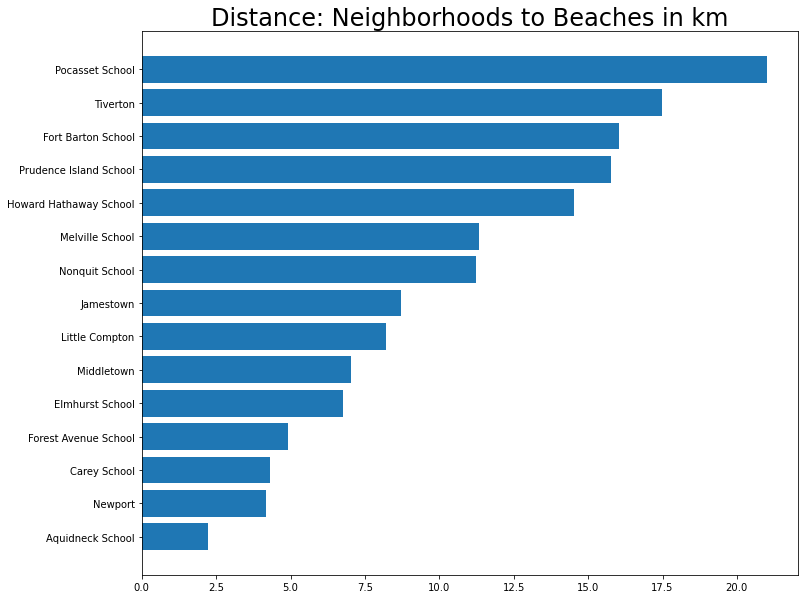

In [28]:
#Finally create a visual to show the average distance to the beaches from each town.
names=avgdis.index
values=avgdis['average distance']
plt.figure(figsize=(40, 10))

plt.subplot(131)
plt.barh(names, values)
plt.rcParams.update({'font.size': 20})
plt.rc('xtick', labelsize=15)
plt.title('Distance: Neighborhoods to Beaches in km')
plt.show()

